### Yelp Restaurant recommender system

**Data Sources**: Yelp Open Dataset's business.json file.

**Motivation:** When visiting a city, people often enjoy restaurants similar to the ones they enjoy at home. We are building a content based recommendation system for restaurants available on Yelp that have the most similar attributes to the one selected by the user, based on the cosine similarity measure.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import great_circle
import sklearn
from sklearn.metrics import pairwise_distances, calinski_harabaz_score
from sklearn.neighbors import DistanceMetric
import ast
import requests
import time
%matplotlib inline

### 2. EDA:  business.json

First, we explore the business.json file which contains each business available in the Yelp DataSet Challenge, including businesses that are not restaurants (For example: Arizona Biltmore Golf Club)

In [36]:
# reading in file
df = pd.read_json('business.json', lines = True) 
df.head(2)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON


- We decide to exclude Canadian cities from our recommendation system and focus on US based restaurants. To do so, we exclude postal codes (zip code) that are longer or shorter than 5 digits.

- For the attributes column, businesses that have "None" as a value are not restaurants and we decide to exclude them from our analysis.

In [37]:
# Dropping Canadian cities

df.postal_code = df.postal_code.apply(lambda x: x if len(x) == 5 else np.nan)

# Dropping Null Attributes and Postal Code columns
df = df[~df['postal_code'].isnull()] 
df = df[~df['attributes'].isnull()]    

# Limiting low frequency cities to 500. Below is the list of cities to keep

keep_city = list(pd.DataFrame(df.groupby('city').filter(lambda x : len(x)>500)['city'].value_counts()).reset_index()['index'])
print('Cities to keep:', keep_city)
df.drop(df[~df.city.isin(keep_city)].index, inplace=True)

df.drop(df[df.is_open == 0].index, inplace = True) # dropping permanently closed businesses
df.drop(['is_open'], axis = 1, inplace = True) # dropping because are all open
df.head(2)


Cities to keep: ['Las Vegas', 'Phoenix', 'Charlotte', 'Scottsdale', 'Pittsburgh', 'Mesa', 'Henderson', 'Tempe', 'Chandler', 'Madison', 'Cleveland', 'Glendale', 'Gilbert', 'Peoria', 'North Las Vegas', 'Champaign', 'Surprise', 'Concord', 'Goodyear', 'Matthews', 'Avondale', 'Huntersville', 'Fort Mill']


,address,attributes,business_id,categories,city,hours,latitude,longitude,name,postal_code,review_count,stars,state
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


Distance between businesses

In [38]:
# Creating tuple for (latitude, longitude)
df_location = df[['business_id','name','city','address','state','latitude','longitude']]
df_location = df_location.reset_index()
df_location['lat_long'] = "(" + df_location['latitude'].map(str) + ',' + df_location['longitude'].map(str) + ")"
df_location['lat_long'] = df_location['lat_long'].apply(ast.literal_eval)

In [44]:
# Business to business distance
# Distance measure : The great-circle distance or orthodromic distance is the shortest distance
# between two points on the surface of a sphere, measured along the surface of the sphere
df_distance_gc = df_location.copy()
for num, val in enumerate(df_location.lat_long):
    ls = []
    for b in df_location.lat_long:
        ls.append(great_circle(val, b).miles)
    df_distance_gc[f"distance_{num}"] = ls
        
df_distance_gc

Next, we need to identify businesses labeled as restaurants based on their "parents" column in the categories.json file. To filter out businesses, we check if each category has its parents column labeled as a restaurant.

In [ ]:
# Categories df

cat = pd.read_json('categories.json')
cat.head(3)

In [ ]:
# Cleaning categories column
df.categories = df.categories.apply(lambda x: x.replace(" ",""))
df.categories = df.categories.str.split(",")
df = df.reset_index().drop(['index'],axis = 1)

In [ ]:
ls = []
for i in range(df.shape[0]):
    if df.categories[i] == None:
        ls.append(np.nan)
    else:
        x = str(cat.parents[cat.title == df.categories[i][0]])
        ls.append(x[x.index("[")+1:x.index("]")])
df["parents"] = ls

# Keeping Restaurants only (Keep if Parents = Restaurant)
df_non_restaurants = df.drop(df[df.parents == 'restaurants'].index)
df = df.drop(df[df.parents != 'restaurants'].index) 
df.head(2)

In [15]:
# Converting Attributes dictionary in dataframe

attributes_df = df.attributes.apply(pd.Series)
attributes_df = pd.concat([df, attributes_df], axis = 1)

#Dropping non-attribute columns
attributes_df = attributes_df.drop(['address', 'attributes','hours',
                                    'latitude', 'longitude', 'name', 'postal_code'], axis = 1)

In [16]:
# Cleaning Attributes

ch = {"u'average'": "'average'","u'quiet'": "'quiet'","u'loud'": "'loud'","u'very_loud'": "'very_loud'"}
attributes_df.NoiseLevel = attributes_df.NoiseLevel.replace(to_replace = ch, value=None)
# attributes_df[(attributes_df.review_count > 50) & (attributes_df.GoodForMeal.isnull() == True)].business_id.count()


attributes_df = attributes_df[attributes_df.GoodForMeal.isnull() == False]
attributes_df = attributes_df.reset_index().drop(['index'], axis = 1)
goodformeal_df = attributes_df.GoodForMeal.apply(ast.literal_eval)
goodformeal_df = goodformeal_df.apply(pd.Series)
attributes_df = pd.concat([attributes_df, goodformeal_df], axis = 1)
cat_df = attributes_df.categories.apply(lambda x: dict(zip(x, [True]*len(x)))).apply(pd.Series)
attributes_df = pd.concat([attributes_df, cat_df], axis = 1)

In [25]:
attributes_df.shape

(4440, 319)

In [26]:
# Categories to drop : low frequency < 5

cat_drop = []
for col in cat_df.columns:
    if cat_df[col].count() <=5:
        cat_drop.append(col)
        
# Dropping from attributes df low frequency columns

for col in cat_drop:
    attributes_df.drop([col],axis =1, inplace=True)

#Remaining categories

len(cat_drop)

137

In [28]:
attributes_df.shape

(4440, 182)

In [29]:
attributes_df = attributes_df[attributes_df.RestaurantsPriceRange2 != 'None']
attributes_df.drop(['categories'],axis = 1)

,business_id,city,review_count,stars,state,parents,RestaurantsTakeOut,BusinessParking,Ambience,RestaurantsDelivery,...,Kebab,HealthMarkets,HotPot,MusicVenues,Kosher,Live/RawFood,Afghan,African,Persian/Iranian,Smokehouse
0,1RHY4K3BD22FK7Cfftn8Mg,Pittsburgh,35,4.0,PA,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'touristy': False, 'hipster': False, 'romanti...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tstimHoMcYbkSC4eBA1wEg,Las Vegas,184,4.5,NV,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'romantic': False, 'intimate': False, 'classy...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,v-scZMU6jhnmV955RSzGJw,Pittsburgh,106,4.5,PA,restaurants,True,"{'garage': False, 'street': True, 'validated':...","{'touristy': False, 'hipster': False, 'romanti...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44YFU284Z3KDEy25QyVoUw,Phoenix,269,3.5,AZ,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'romantic': False, 'intimate': False, 'touris...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nsNONDHbV7Vudqh21uicqw,Scottsdale,526,3.5,AZ,restaurants,False,"{'garage': False, 'street': False, 'validated'...","{'touristy': False, 'hipster': False, 'romanti...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6fPQJq4f_yiq1NHn0fd11Q,Las Vegas,535,3.5,NV,restaurants,True,"{'garage': True, 'street': False, 'validated':...","{'romantic': False, 'intimate': False, 'touris...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,k-dDZvTeLysoJvjHI-qr9g,Las Vegas,287,3.0,NV,restaurants,False,"{'garage': True, 'street': False, 'validated':...","{'romantic': False, 'intimate': False, 'touris...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,F6c3D1o9Z4Tl6cDorb3WgA,Pittsburgh,75,3.5,PA,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'romantic': False, 'intimate': False, 'classy...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,hXzoNgpkC86K_Jfg_zMHvA,Glendale,96,4.5,AZ,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'touristy': False, 'hipster': False, 'romanti...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,AMN3Sgns9tB2x-b3eWk0qQ,Scottsdale,457,4.0,AZ,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'romantic': False, 'intimate': False, 'touris...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
clean_df = attributes_df.drop(['categories','city','state','parents','RestaurantsTakeOut',
                   'RestaurantsDelivery','DriveThru','GoodForMeal','WiFi',
                   'Caters','RestaurantsTableService','BYOBCorkage','Corkage',
                   'BYOB','CoatCheck','Smoking','GoodForDancing','DogsAllowed',
                   'BusinessAcceptsBitcoin','ByAppointmentOnly','AgesAllowed',
                   'Open24Hours','DietaryRestrictions','RestaurantsCounterService',
                   'AcceptsInsurance','Music','BestNights', 'HappyHour'],axis = 1)

In [32]:
# Number of Ambience null values to drop
sum(clean_df.Ambience.isnull())

116

In [33]:
# Unpacking Ambience dictionary & dropping null values

clean_df = clean_df[clean_df.Ambience.isnull() == False]
ambience_df = clean_df.Ambience.apply(ast.literal_eval)
ambience_df = ambience_df.apply(pd.Series)
clean_df = pd.concat([clean_df, ambience_df], axis = 1)
clean_df.drop(['Ambience'],axis = 1,inplace = True)
clean_df.head(2)

,business_id,review_count,stars,BusinessParking,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,...,Smokehouse,touristy,hipster,romantic,divey,intimate,trendy,upscale,classy,casual
0,1RHY4K3BD22FK7Cfftn8Mg,35,4.0,"{'garage': False, 'street': False, 'validated'...",False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tstimHoMcYbkSC4eBA1wEg,184,4.5,"{'garage': False, 'street': False, 'validated'...",False,True,1,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [34]:
clean_df[clean_df.BusinessParking.isnull() == True]

,business_id,review_count,stars,BusinessParking,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,...,Smokehouse,touristy,hipster,romantic,divey,intimate,trendy,upscale,classy,casual
30,iE71iwcSljg3xm2GB2Y9aA,497,4.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50,lqPuSiWypNCACEMhArSZ2A,22,2.5,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,gPZj-XXVwFHgd8zjJPzVCw,12,3.5,NaN,False,True,1,True,True,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,QzvLnOqwH6BIY_jCOvzuQQ,30,2.5,NaN,False,True,2,False,False,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158,xVWLSFGNr4w4DYvYiafMPw,10,4.0,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,9q8phddM1YWNKZVepKi6iQ,10,3.0,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189,8CjI8nebSDB5aINJc3dLwA,13,4.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,Kzo1z1hW6224lNd3al2SbQ,29,3.5,NaN,False,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
236,oNCF7oHyKYlGLu_kHV2MSg,9,2.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,MYB1ZMspBk1Xc_awp_PtSw,79,3.5,NaN,False,True,2,True,False,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [35]:
clean_df[clean_df.BusinessParking.isnull() == True]

,business_id,review_count,stars,BusinessParking,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,...,Smokehouse,touristy,hipster,romantic,divey,intimate,trendy,upscale,classy,casual
30,iE71iwcSljg3xm2GB2Y9aA,497,4.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50,lqPuSiWypNCACEMhArSZ2A,22,2.5,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,gPZj-XXVwFHgd8zjJPzVCw,12,3.5,NaN,False,True,1,True,True,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,QzvLnOqwH6BIY_jCOvzuQQ,30,2.5,NaN,False,True,2,False,False,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158,xVWLSFGNr4w4DYvYiafMPw,10,4.0,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,9q8phddM1YWNKZVepKi6iQ,10,3.0,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189,8CjI8nebSDB5aINJc3dLwA,13,4.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,Kzo1z1hW6224lNd3al2SbQ,29,3.5,NaN,False,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
236,oNCF7oHyKYlGLu_kHV2MSg,9,2.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,MYB1ZMspBk1Xc_awp_PtSw,79,3.5,NaN,False,True,2,True,False,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
# Unpacking Parking column - replacing null values by no street parking

parking_df = clean_df.BusinessParking.replace(to_replace = np.nan, value = "{'street':False}")
parking_df = parking_df.apply(ast.literal_eval)
parking_df = parking_df.apply(pd.Series)

In [37]:
# Assigning Boolean value to parking: True if garage, validated, lot, valet parking available; False otherwise.

parking_df['parking'] = parking_df['garage']|parking_df['validated']|parking_df['lot']|parking_df['valet']
parking_df.drop(['garage','street','validated','lot','valet'], axis = 1, inplace=True)
clean_df = pd.concat([clean_df, parking_df], axis = 1)
clean_df.drop(['BusinessParking'],axis = 1,inplace = True)

In [38]:
#Cleaning Restaurants Attire

attire = {"u'casual'": "'casual'","u'dressy'": "'dressy'","u'formal'":"'dressy'","'formal'":"'dressy'"}
clean_df.RestaurantsAttire = clean_df.RestaurantsAttire.replace(to_replace = attire, value=None)

In [39]:
#Cleaning Alcohol

alc = {"u'none'": "False","'none'": "False","None": "False","u'full_bar'": "True","'full_bar'": "True",
      "u'beer_and_wine'": "True","'beer_and_wine'":"True"}
clean_df.Alcohol = clean_df.Alcohol.replace(to_replace = alc, value=None)

In [40]:
clean_df.WheelchairAccessible.value_counts()

True     954
False     52
None       4
Name: WheelchairAccessible, dtype: int64

In [41]:
clean_df.head(3)

,business_id,review_count,stars,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,OutdoorSeating,...,touristy,hipster,romantic,divey,intimate,trendy,upscale,classy,casual,parking
0,1RHY4K3BD22FK7Cfftn8Mg,35,4.0,False,True,1,True,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,tstimHoMcYbkSC4eBA1wEg,184,4.5,False,True,1,True,True,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True
2,v-scZMU6jhnmV955RSzGJw,106,4.5,False,True,2,False,True,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False


In [42]:
# Filling NA values

clean_df.RestaurantsPriceRange2.fillna(1, inplace = True)
clean_df.RestaurantsPriceRange2.isna().sum()

0

In [43]:
clean_df.RestaurantsAttire.value_counts()

'casual'    4121
'dressy'      91
Name: RestaurantsAttire, dtype: int64

In [44]:


wch = {False:0, True:1,'False':0, 'True':1,'None':0}
clean_df.WheelchairAccessible = clean_df.WheelchairAccessible.replace(to_replace = wch, value=None)
clean_df.GoodForKids = clean_df.GoodForKids.replace(to_replace = wch, value=None)
clean_df.HasTV = clean_df.HasTV.replace(to_replace = wch, value=None)
clean_df.OutdoorSeating = clean_df.OutdoorSeating.replace(to_replace = wch, value=None)
clean_df.BikeParking = clean_df.BikeParking.replace(to_replace = wch, value=None)
clean_df.Alcohol = clean_df.Alcohol.replace(to_replace = wch, value=None)
clean_df.BusinessAcceptsCreditCards = clean_df.BusinessAcceptsCreditCards.replace(to_replace = wch, value=None)
clean_df.RestaurantsReservations = clean_df.RestaurantsReservations.replace(to_replace = wch, value=None)
clean_df.RestaurantsGoodForGroups = clean_df.RestaurantsGoodForGroups.replace(to_replace = wch, value=None)

clean_df.RestaurantsAttire.fillna("'casual'", inplace = True)  

clean_df.NoiseLevel = clean_df.NoiseLevel.replace('None', value="'average'")
clean_df.NoiseLevel.fillna("'average'", inplace = True)  

clean_df.WheelchairAccessible.fillna(2, inplace = True)  # 2 means unknown
clean_df.fillna(0, inplace=True)
clean_df = clean_df.replace(to_replace = wch, value=None)

In [45]:
# change type
clean_df.RestaurantsPriceRange2 = clean_df.RestaurantsPriceRange2.astype(int)

In [46]:
clean_df = pd.concat([clean_df,pd.get_dummies(clean_df.NoiseLevel),pd.get_dummies(clean_df.RestaurantsAttire)],
                     axis = 1)
clean_df.drop(['NoiseLevel','RestaurantsAttire'], axis = 1, inplace = True)

In [47]:
clean_df.head(2)

,business_id,review_count,stars,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,OutdoorSeating,...,upscale,classy,casual,parking,'average','loud','quiet','very_loud','casual','dressy'
0,1RHY4K3BD22FK7Cfftn8Mg,35,4.0,0.0,1.0,1,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0,1,0,0,0,1,0
1,tstimHoMcYbkSC4eBA1wEg,184,4.5,0.0,1.0,1,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1,1,0,0,0,1,0


In [257]:
clean_df = clean_df.reset_index()

In [260]:
clean_df.drop(['index'],axis = 1, inplace= True)

### Part 2: Modeling

In [261]:
X = clean_df.drop(['business_id'], axis = 1)

In [262]:
X.shape

(4322, 165)

### Cosine Distance & Similarity

Cosine distance is defined as 1.0 minus the cosine similarity.

Therefore, the smaller the value is in the Cosine distance matrix, the more the businesses are similar.

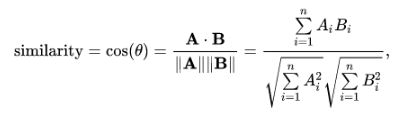

In [264]:
similarity_matrix = pd.DataFrame(pairwise_distances(X, metric='cosine'), columns=clean_df.iloc[:,0])
similarity_matrix.head(2)

business_id,1RHY4K3BD22FK7Cfftn8Mg,tstimHoMcYbkSC4eBA1wEg,v-scZMU6jhnmV955RSzGJw,44YFU284Z3KDEy25QyVoUw,nsNONDHbV7Vudqh21uicqw,6fPQJq4f_yiq1NHn0fd11Q,k-dDZvTeLysoJvjHI-qr9g,F6c3D1o9Z4Tl6cDorb3WgA,hXzoNgpkC86K_Jfg_zMHvA,AMN3Sgns9tB2x-b3eWk0qQ,...,KOEBBp2PhiV_4PkW9eo9Sg,kOo4ZY2UQAX4j312mzQ8mA,epR6riXzEtGRmao3gB6yiw,jJZwQj3Pwv1OMZ8bQpKxnw,Lhl72icGvaW2rFClTy-hog,qRymrsLmlA34bC8PvNoujg,P8uECqGqXWTwEndkh-6bQw,p5rpYtxS5xPQjt3MXYVEwA,I3dQmMkfqMsThMAuqIkooA,JsRt9LPgv-7guVcY4u6OQA
0,0.000000,0.008589,0.006831,0.009925,0.011088,0.011104,0.010503,0.004733,0.006062,0.010779,...,0.011046,0.006746,0.009180,0.004523,0.007481,0.011102,0.011106,0.011265,0.008398,0.007868
1,0.008589,0.000000,0.000531,0.000179,0.000361,0.000369,0.000255,0.001255,0.000752,0.000286,...,0.000335,0.010077,0.011976,0.010835,0.000416,0.000347,0.000363,0.000388,0.000220,0.000297


In [265]:
similarity_matrix.shape

(4322, 4322)

In [266]:
df_similarity = pd.concat([clean_df.iloc[:,0],similarity_matrix], axis=1)

In [ ]:
similarity_matrix.iloc[0].sort_values()

In [ ]:
sorted(list(similarity_matrix.iloc[0]))[1:11]

In [272]:
df_test.name = df_test.name.str.lower()
df_test[["name", "city", "state"]] = df_test[["name", "city", "state"]].apply(lambda x: x.str.lower())
df_test.drop(['index'], axis=1, inplace=True)

In [398]:
df_distance = df_test.iloc[:,8:]
df_distance.columns = df_test.business_id
df_distance.columns.name = None

# df_distance.index.rename('index', inplace = True)
df_distance['business_id'] = df_test.business_id

In [399]:
df_distance.head()

,1RHY4K3BD22FK7Cfftn8Mg,tstimHoMcYbkSC4eBA1wEg,v-scZMU6jhnmV955RSzGJw,44YFU284Z3KDEy25QyVoUw,nsNONDHbV7Vudqh21uicqw,6fPQJq4f_yiq1NHn0fd11Q,k-dDZvTeLysoJvjHI-qr9g,MhnihE0alud0ereVInSt8Q,OwXMxqxIy4YoprAjnoUoiA,c7JoAt6a3Ufkpn3TrGU23A,...,jJZwQj3Pwv1OMZ8bQpKxnw,Lhl72icGvaW2rFClTy-hog,MBHGhr936i0slW9Bw4XIYA,qRymrsLmlA34bC8PvNoujg,P8uECqGqXWTwEndkh-6bQw,p5rpYtxS5xPQjt3MXYVEwA,I3dQmMkfqMsThMAuqIkooA,VD358OTsTLFuxOZJTOInKQ,JsRt9LPgv-7guVcY4u6OQA,business_id
index,,,,,,,,,,,,,,,,,,,,,
0,0.000000,1896.218531,13.373132,1802.405549,1803.452266,1905.028469,1904.487475,1803.583073,100.785192,1813.990800,...,1906.441765,1816.225259,1800.053942,1907.003352,1906.050079,1904.329920,1791.217617,502.687067,350.710366,1RHY4K3BD22FK7Cfftn8Mg
1,1896.218531,0.000000,1909.189163,248.916792,259.610302,9.285653,8.324442,257.736379,1824.775165,253.205465,...,14.167176,239.065662,271.231617,15.197573,9.907874,12.504023,267.904374,1439.165847,1905.454014,tstimHoMcYbkSC4eBA1wEg
2,13.373132,1909.189163,0.000000,1814.849672,1815.863613,1917.993862,1917.456388,1815.999895,112.594892,1826.412216,...,1919.394789,1828.685916,1812.433351,1919.992747,1919.018514,1917.283467,1803.615640,515.954697,348.460720,v-scZMU6jhnmV955RSzGJw
3,1802.405549,248.916792,1814.849672,0.000000,11.638623,250.209531,251.719189,9.740319,1741.002240,14.111701,...,244.780139,15.050686,22.813172,263.278912,252.198811,244.040899,19.701061,1382.067744,1768.216828,44YFU284Z3KDEy25QyVoUw
4,1803.452266,259.610302,1815.863613,11.638623,0.000000,260.729964,262.266177,1.927939,1742.589697,11.125657,...,255.211975,21.742993,11.621413,273.880670,262.716591,254.513915,13.092982,1385.178412,1766.910632,nsNONDHbV7Vudqh21uicqw


In [400]:
df_final = df_similarity.merge(df_test[['name', 'business_id', 'city', 'state']], on='business_id')

In [401]:
df_final.head()

,business_id,1RHY4K3BD22FK7Cfftn8Mg,tstimHoMcYbkSC4eBA1wEg,v-scZMU6jhnmV955RSzGJw,44YFU284Z3KDEy25QyVoUw,nsNONDHbV7Vudqh21uicqw,6fPQJq4f_yiq1NHn0fd11Q,k-dDZvTeLysoJvjHI-qr9g,F6c3D1o9Z4Tl6cDorb3WgA,hXzoNgpkC86K_Jfg_zMHvA,...,jJZwQj3Pwv1OMZ8bQpKxnw,Lhl72icGvaW2rFClTy-hog,qRymrsLmlA34bC8PvNoujg,P8uECqGqXWTwEndkh-6bQw,p5rpYtxS5xPQjt3MXYVEwA,I3dQmMkfqMsThMAuqIkooA,JsRt9LPgv-7guVcY4u6OQA,name,city,state
0,1RHY4K3BD22FK7Cfftn8Mg,0.000000,0.008589,0.006831,0.009925,0.011088,0.011104,0.010503,0.004733,0.006062,...,0.004523,0.007481,0.011102,0.011106,0.011265,0.008398,0.007868,marathon diner,pittsburgh,pa
1,tstimHoMcYbkSC4eBA1wEg,0.008589,0.000000,0.000531,0.000179,0.000361,0.000369,0.000255,0.001255,0.000752,...,0.010835,0.000416,0.000347,0.000363,0.000388,0.000220,0.000297,maria's mexican restaurant & bakery,las vegas,nv
2,v-scZMU6jhnmV955RSzGJw,0.006831,0.000531,0.000000,0.000804,0.001160,0.001161,0.000957,0.000984,0.000527,...,0.008627,0.000363,0.001131,0.001179,0.001218,0.000676,0.000426,no. 1 sushi sushi,pittsburgh,pa
3,44YFU284Z3KDEy25QyVoUw,0.009925,0.000179,0.000804,0.000000,0.000081,0.000091,0.000058,0.001694,0.001147,...,0.012537,0.000605,0.000081,0.000097,0.000113,0.000217,0.000401,nee house chinese restaurant,phoenix,az
4,nsNONDHbV7Vudqh21uicqw,0.011088,0.000361,0.001160,0.000081,0.000000,0.000023,0.000068,0.002282,0.001634,...,0.014220,0.000948,0.000022,0.000017,0.000030,0.000414,0.000662,salt cellar,scottsdale,az


#### Best_restaurant function

> Returns dataframe with most similar restaurant. If destination city is mentioned, it returns most similar restaurants in the destination city. 

In [456]:
def best_restaurant(name, city=None, num = 10):
    business = df_final[df_final['name'] == name].business_id
    biz_id = business.tolist()[0]
    rec_df = df_final[[biz_id, 'name', 'city', 'state', 'business_id']].merge(df_distance[['business_id', biz_id]], on='business_id')
    
    if city == None:
        return rec_df.sort_values(by=f"{biz_id}_x", ascending=True)[1:num]
    else:
        rec_df = rec_df[rec_df['city']==city.lower()]
        return rec_df.sort_values(by=f"{biz_id}_x", ascending=True)[1:num]
        

In [463]:
a = best_restaurant("maria's mexican restaurant & bakery")

In [922]:
X_dessert = clean_df.copy()
X_dessert['has_dessert'] = X_dessert['dessert']+X_dessert['Desserts']+X_dessert['BubbleTea']+X_dessert['Cafes']+X_dessert['Creperies']+X_dessert['IceCream&FrozenYogurt']+X_dessert['Waffles']
X_dessert = X_dessert[X_dessert['has_dessert'] != 0]
X_dessert.shape


(589, 167)

In [923]:
def find_closest(name):
    business = df_final[df_final['name'] == name].business_id
    biz_id = business.tolist()[0]
    rec_df = df_final[[biz_id, 'name', 'city', 'state', 'business_id']].merge(df_distance[['business_id', biz_id]], on='business_id')
    return rec_df.sort_values(by=f"{biz_id}_y", ascending=True)
    

In [944]:
def find_dessert(name, max_dist = 5, num = 10 ):
    df = find_closest(name)
    df = df[df[df.columns[-1]] <= max_dist]
    desserts = X_dessert.merge(df, how = 'inner', on = 'business_id')
    desserts = desserts.sort_values(by = ["has_dessert",desserts.columns[-1]], ascending = [False, True])
    return desserts


In [946]:
find_dessert("maria's mexican restaurant & bakery", max_dist = 5)

,business_id,review_count,stars,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,OutdoorSeating,...,'quiet','very_loud','casual','dressy',has_dessert,tstimHoMcYbkSC4eBA1wEg_x,name,city,state,tstimHoMcYbkSC4eBA1wEg_y
1,IUe5DI53ZH2_U8B0PKJ5sw,70,4.5,0.0,1.0,1,1.0,1.0,1.0,0.0,...,0,0,1,0,3.0,0.002211,crepe station,las vegas,nv,2.427810
3,2_hC_X9K080F8zWP4UUB4g,27,3.5,1.0,1.0,1,1.0,1.0,1.0,1.0,...,0,0,1,0,3.0,0.015518,chamango,north las vegas,nv,3.750978
4,DDs5YMhAjnP6oA5-eGw_TQ,36,2.0,0.0,1.0,1,1.0,1.0,0.0,1.0,...,0,0,1,0,1.0,0.006688,sonic drive-in,las vegas,nv,2.153039
5,82kehL5xSvGbLYTmF_f2Vg,35,3.5,1.0,1.0,1,1.0,1.0,1.0,0.0,...,0,0,1,0,1.0,0.006901,crepes n' tacos mexican grill,las vegas,nv,2.413293
2,ARGQeEn17fhIdfij07FwNw,43,4.5,0.0,1.0,2,1.0,1.0,1.0,0.0,...,1,0,1,0,1.0,0.007322,viva el taco express,las vegas,nv,2.618408
0,zTkMh_RUVZW-J3lh7-l09Q,35,3.5,1.0,1.0,2,1.0,1.0,0.0,0.0,...,1,0,1,0,1.0,0.011256,boulder station pasta cucina,las vegas,nv,4.969532


### Visualizations

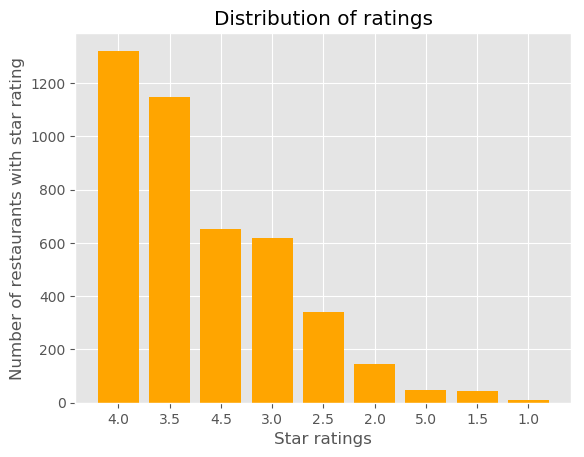

<Figure size 1200x800 with 0 Axes>

In [612]:
import collections
stars = clean_df.stars.value_counts().to_dict()

plt.bar(range(len(stars)), stars.values(), align='center', color = 'orange')
plt.xticks(range(len(stars.keys())), stars.keys())
plt.ylabel('Number of restaurants with star rating')
plt.xlabel('Star ratings')
plt.title('Distribution of ratings')
plt.figure(figsize=(12,8))
plt.show()

In [947]:
find_closest('marathon diner').head(2)

,1RHY4K3BD22FK7Cfftn8Mg_x,name,city,state,business_id,1RHY4K3BD22FK7Cfftn8Mg_y
0,0.000000,marathon diner,pittsburgh,pa,1RHY4K3BD22FK7Cfftn8Mg,0.000000
2908,0.013708,bruegger's bagels,pittsburgh,pa,iR6kEMdNRFc9QZUNTQo5Zg,0.245643


In [948]:
df_2 = df_location.merge(best_restaurant('marathon diner'), on='business_id')
df_2.sort_values(by = df_2.columns[-5])

,index,business_id,name_x,city_x,address,state_x,latitude,longitude,lat_long,1RHY4K3BD22FK7Cfftn8Mg_x,name_y,city_y,state_y,1RHY4K3BD22FK7Cfftn8Mg_y
4,43723,AyamCmzsGAVluH8MDQsJbA,Big Shot Bob's House of Wings - South Side,Pittsburgh,1324 E Carson St,PA,40.428626,-79.984229,"(40.4286261, -79.9842293)",0.002047,big shot bob's house of wings - south side,pittsburgh,pa,14.531414
1,11819,OAsYaD7nLC2kDuqO4uaoIQ,Badamo's Pizza,Pittsburgh,1106 Federal St,PA,40.455804,-80.006590,"(40.4558035304, -80.00658983)",0.002073,badamo's pizza,pittsburgh,pa,12.888957
6,53625,xxaqaD9IVsqxiNF8FoHdYA,Port of Subs,Las Vegas,"6005 S Fort Apache Rd, Ste 120",NV,36.079437,-115.298066,"(36.0794375, -115.2980657)",0.002107,port of subs,las vegas,nv,1912.458725
8,75131,AVCD-zzzeaNvC-znOZEhsg,Salad and Go,Scottsdale,2323 N Scottsdale Rd,AZ,33.473673,-111.925499,"(33.4736728646, -111.9254992479)",0.002361,salad and go,scottsdale,az,1803.731250
3,30298,bFUWmRKsCkborKVe6oaA5g,Jack in the Box,Las Vegas,7151 W Craig Rd,NV,36.238173,-115.250283,"(36.2381728, -115.2502832)",0.002397,jack in the box,las vegas,nv,1906.240315
0,6436,Z35sWrHZ8pfaHRuXLZc0lQ,South 21 Matthews,Matthews,11450 E Independence Blvd,NC,35.115311,-80.695147,"(35.1153113, -80.6951474)",0.002446,south 21 matthews,matthews,nc,372.588353
7,64159,M_JZsxuSquWmqcETqz3bNg,Krazy Sub-Steve's,Mesa,1211 N Country Club Dr,AZ,33.436521,-111.839182,"(33.436521, -111.839182)",0.002589,krazy sub-steve's,mesa,az,1800.296247
5,53199,AVtNuwwdgWWm2CZqRe5pKQ,San Gennaro Burger,Las Vegas,3355 Las Vegas Blvd S,NV,36.121545,-115.169702,"(36.121545, -115.169702)",0.002636,san gennaro burger,las vegas,nv,1904.730392
2,12214,SYmlrGAfgHaKhHMn21y7Gw,Ned's Krazy Sub,Mesa,1927 N Gilbert Rd,AZ,33.450313,-111.787141,"(33.450313, -111.787141)",0.002711,ned's krazy sub,mesa,az,1797.173581


In [990]:
# Create a map using the Map() function and the coordinates for JFK Airport
# tiles : 'CartoDB dark_matter' or 'Stamen Terrain'

import folium
def map_closest(name, num = 1000):
    df_loc = df_location.merge(find_closest(name.lower()), on='business_id')
    df_loc = df_loc.sort_values(by = df_loc.columns[-1])
    df_recommend  = df_loc.iloc[1:num+1,:]
    
    start_lat = list(df_loc.iloc[:1,6])[0]
    start_long = list(df_loc.iloc[:1,7])[0]
    
    m = folium.Map(location=[start_lat, start_long],zoom_start=15,tiles = 'Stamen Terrain')
    
    # Adds location of restaurant the user likes
    
    folium.Marker(location=(start_lat,
                                      start_long),
                            popup = f"You enjoyed: {name}", icon=folium.Icon(color='pink', icon='heart',prefix = 'fa')
                     ).add_to(m)

    
    for index, row in df_recommend.iterrows():

        popup_text = "Restaurant: {} "
        popup_text = popup_text.format(row[f'name_y'])

        folium.Marker(location=(row['latitude'],
                                      row['longitude']),
                            popup = popup_text, icon=folium.Icon(color='orange', icon='cutlery',prefix = 'fa')
                     ).add_to(m)
    return m

In [991]:
import ipywidgets as widgets
from ipywidgets import interact, Layout, Label


style = {'description_width': 'initial'}
inter = interact(map_closest, name = widgets.Dropdown(
    options=df_final.name.str.title(),
    description='Select a Restaurant you enjoy:',
    disabled=False, layout = Layout(width = '60%', height = '50px'), style =style
),num = widgets.IntSlider(value=15, description = "Select the number of recommendations",
                                               min=0,
                                               max=100,
                                               step=1,layout = Layout(width = '65%', height = '80px'), style =style))


interactive(children=(Dropdown(description='Select a Restaurant you enjoy:', layout=Layout(height='50px', widt…

In [987]:
# Map of restaurants most similar to the user input.

def map_recommendations(name, city, num = 1000):
    df_loc = df_location.merge(best_restaurant(name.lower(), city), on='business_id')
    df_loc = df_loc.sort_values(by = df_loc.columns[-1])
    df_recommend  = df_loc.iloc[1:num+1,:]
    
    start_lat = list(df_loc.iloc[:1,6])[0]
    start_long = list(df_loc.iloc[:1,7])[0]
    
    m = folium.Map(location=[start_lat, start_long],zoom_start=5,tiles = 'Stamen Terrain')

    for index, row in df_recommend.iterrows():

        popup_text = "Restaurant: {} "
        popup_text = popup_text.format(row[f'name_y'])

        folium.Marker(location=(row['latitude'],
                                      row['longitude']),
                            popup = popup_text, icon=folium.Icon(color='orange', icon='cutlery',prefix = 'fa')
                     ).add_to(m)
    return m

In [862]:
style = {'description_width': 'initial'}
inter = interact(map_recommendations, name = widgets.Dropdown(
options=df_final.name.str.title(),
description='Select a Restaurant you enjoy:',
disabled=False, layout = Layout(width = '60%', height = '50px'), style =style
),city = widgets.Dropdown(
options=list(set(df_final.city.str.title())),
description='Select destination city:',
disabled=False, layout = Layout(width = '60%', height = '50px'), style =style
), num = widgets.IntSlider(value=15, description = "Select the number of recommendations",
                                           min=0,
                                           max=100,
                                           step=1,layout = Layout(width = '65%', height = '80px'), style =style))


interactive(children=(Dropdown(description='Select a Restaurant you enjoy:', layout=Layout(height='50px', widt…

### Recommendation of closest dessert location

In [981]:
def map_closest_dessert(name, max_dist = 5 , num = 1000):
    df_loc = df_location.merge(find_dessert(name.lower(), max_dist = max_dist), on='business_id')
    df_loc = df_loc.sort_values(by = df_loc.columns[-1])
    df_recommend  = df_loc.iloc[1:num+1,:]
    
    start_lat = list(df_loc.iloc[:1,6])[0]
    start_long = list(df_loc.iloc[:1,7])[0]
    
    m = folium.Map(location=[start_lat, start_long],zoom_start=15,tiles = 'Stamen Terrain')
    
    # Adds location where user had dinner
    folium.Marker(location=(start_lat,
                                      start_long),
                            popup = f"You had dinner at {name}", icon=folium.Icon(color='blue', icon='cutlery',prefix = 'fa')
                     ).add_to(m)

    
    for index, row in df_recommend.iterrows():

        popup_text = "Restaurant: {} "
        popup_text = popup_text.format(row[f'name_y'])

        folium.Marker(location=(row['latitude'],
                                      row['longitude']),
                            popup = popup_text, icon=folium.Icon(color='orange', icon='coffee',prefix = 'fa')
                     ).add_to(m)
    return m

In [982]:
style = {'description_width': 'initial'}
inter = interact(map_closest_dessert, name = widgets.Dropdown(
options=df_final.name.str.title(),
description='Select the restaurant you had dinner at:',
disabled=False, layout = Layout(width = '60%', height = '50px'), style =style
),max_dist = widgets.IntSlider(value = 6,description = "Select how far you are willing to go for dessert!:",
                                           min=0,
                                           max=100,
                                           step=1,layout = Layout(width = '50%', height = '80px'), style =style),
                 num = widgets.IntSlider(value=2, description = "Select the number of recommendations",
                                           min=0,
                                           max=100,
                                           step=1,layout = Layout(width = '50%', height = '80px'), style =style))


interactive(children=(Dropdown(description='Select the restaurant you had dinner at:', layout=Layout(height='5…

### Bar recommendation

In [901]:
# Indicator of Bar

bar_indice = ['Alcohol','latenight','Bars','Nightlife','CocktailBars','WineBars','Venues&EventSpaces','DiveBars',
              'Gastropubs','Breweries','Brasseries','BeerBar','Lounges','Karaoke','MusicVenues','divey',"'loud'",
              "'very_loud'"]

In [983]:
# Subset of bars only
X_bar = clean_df.copy()
X_bar['has_bar'] = X_bar[bar_indice].sum(axis=1)
X_bar = X_bar[X_bar['has_bar'] != 0]
X_bar.head(2)

,business_id,review_count,stars,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,OutdoorSeating,...,classy,casual,parking,'average','loud','quiet','very_loud','casual','dressy',has_bar
1,tstimHoMcYbkSC4eBA1wEg,184,4.5,0.0,1.0,1,1.0,1.0,1.0,0.0,...,0.0,1.0,1,1,0,0,0,1,0,3.0
3,44YFU284Z3KDEy25QyVoUw,269,3.5,1.0,1.0,2,1.0,1.0,0.0,0.0,...,0.0,1.0,1,1,0,0,0,1,0,1.0


In [984]:
# Function to find the closest bar to where the user had dinner at.

def find_bar(name, max_dist = 5, num = 10 ):
    df = find_closest(name)
    df = df[df[df.columns[-1]] <= max_dist]
    bar = X_bar.merge(df, how = 'inner', on = 'business_id')
    bar = bar.sort_values(by = ["has_bar",bar.columns[-1]], ascending = [False, True])
    return bar


In [985]:
# Function to create a map with the closest bar to where the user had dinner at.

def map_closest_bar(name, max_dist = 5 , num = 1000):
    df_loc = df_location.merge(find_bar(name.lower(), max_dist = max_dist), on='business_id')
    df_loc = df_loc.sort_values(by = df_loc.columns[-1])
    df_recommend  = df_loc.iloc[1:num+1,:]
    
    start_lat = list(df_loc.iloc[:1,6])[0]
    start_long = list(df_loc.iloc[:1,7])[0]
    
    m = folium.Map(location=[start_lat, start_long],zoom_start=15,tiles = 'Stamen Terrain')
    
    # Adds location where user had dinner
    folium.Marker(location=(start_lat,
                                      start_long),
                            popup = f"You had dinner at {name}", icon=folium.Icon(color='blue', icon='cutlery',prefix = 'fa')
                     ).add_to(m)
    
    for index, row in df_recommend.iterrows():

        popup_text = "Bar : {} "
        popup_text = popup_text.format(row[f'name_y'])

        folium.Marker(location=(row['latitude'],
                                      row['longitude']),
                            popup = popup_text, icon=folium.Icon(color='orange', icon='glass',prefix = 'fa')
                     ).add_to(m)
    return m

In [986]:
# User interface

style = {'description_width': 'initial'}
inter = interact(map_closest_bar, name = widgets.Dropdown(
options=df_final.name.str.title(),
description='Select the restaurant you had dinner at:',
disabled=False, layout = Layout(width = '60%', height = '50px'), style =style
),max_dist = widgets.IntSlider(value = 6,description = "Select how far you are willing to go for a Bar!:",
                                           min=0,
                                           max=100,
                                           step=1,layout = Layout(width = '50%', height = '80px'), style =style),
                 num = widgets.IntSlider(value=2, description = "Select the number of recommendations",
                                           min=0,
                                           max=100,
                                           step=1,layout = Layout(width = '50%', height = '80px'), style =style))


interactive(children=(Dropdown(description='Select the restaurant you had dinner at:', layout=Layout(height='5…